In [1]:
pip install pybedtools -i https://pypi.org/simple/

Looking in indexes: https://pypi.org/simple/
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import os
####将09insulation/cooltools_insulation下所有_insul.tsv合并到一个bed
##另外，ls *tsv > ../../../08TAD/filename  删掉非GBM样本名

# 指定的目录路径
directory_path = '/cluster/home/tmp/GBM/HiC/09insulation/insul_futing/50k'
with open('/cluster/home/tmp/GBM/HiC/08TAD/filename', 'r') as file:
    filenames = file.read().splitlines()
file_names = [filename.replace('_insul.tsv', '') for filename in filenames]

#读取第一个文件并设置列名
first_df = pd.read_csv(
    os.path.join(directory_path, f"{file_names[0]}_insul.tsv"),
    sep='\t',
    header=0,
    usecols=['chrom', 'start', 'end', 'is_boundary_800000']  # 指定需要读取的列
)
first_df.columns = ['chrom', 'start', 'end', f"{file_names[0]}"]

# 从第二个文件开始处理
for file_name in file_names[1:]:
    # 读取文件
    current_df = pd.read_csv(os.path.join(directory_path, f"{file_name}_insul.tsv"), sep='\t', header=0,usecols=['is_boundary_800000'])
    
    # 只保留第9列，并将列名设置为去掉'_insul.tsv'后缀的文件名
    current_df.columns = [f"{file_name}"]
    
    # 横向合并
    first_df = pd.concat([first_df, current_df], axis=1)

# 保存到新的bed文件
output_file_path = '/cluster/home/tmp/GBM/HiC/08TAD/all.bed'
first_df.to_csv(output_file_path, sep='\t', index=False)

#print(first_df)
print(first_df.shape[0], first_df.shape[1])


60630 70


In [3]:
###只保留在所有样本最后一列都是true的行
bool_columns = first_df.iloc[:, 3:]

# 使用 all() 函数沿着每行检查这些列是否都是 True
bool_index = bool_columns.all(axis=1)

# 使用布尔索引来提取满足条件的行
filtered_df = first_df[bool_index]
# 只保留前3列
filtered_df1 = filtered_df.iloc[:, :3]

# 打印结果
print(filtered_df1.shape[0],filtered_df1.shape[1])
output_file_path = '/cluster/home/tmp/GBM/HiC/08TAD/sameBIN_67GBM.bed'
filtered_df1.to_csv(output_file_path, sep='\t', index=False)



49 3


In [49]:
###在2/3中算保守
# 选择第四列到最后一列的所有列
bool_columns = first_df.iloc[:, 3:]

# 使用 sum() 函数计算每行中 True 的个数
bool_counts = (bool_columns == True).sum(axis=1)

# 使用布尔索引来提取满足条件的行，即每行中有大于等于2/3 True
filtered_df = first_df[bool_counts > 64]
filtered_df1 = filtered_df.iloc[:, :3]

# 打印结果
print(filtered_df1.shape[0],filtered_df1.shape[1])
output_file_path = '/cluster/home/tmp/GBM/HiC/08TAD/sameBIN_67GBMover64.bed'
filtered_df1.to_csv(output_file_path, sep='\t', index=False)

181 3


In [58]:
#处理NPC的boundary
output_field_separator = "\t"

# 打开输入文件和输出文件
with open('/cluster/home/tmp/GBM/HiC/09insulation/insul_futing/50k/NPC_new_insul.tsv', 'r') as input_file, \
     open('/cluster/home/tmp/GBM/HiC/08TAD/NPC_boundary.bed', 'w') as output_file:
    # 读取每一行
    for line in input_file:
        # 跳过第一行（假设第一行为标题行）
        if line.startswith("#") or line.strip() == "":
            continue
        
        # 分割行中的字段
        fields = line.strip().split("\t")
        
        # 检查是否为第9列的值是"True"
        if fields[8] == "True":  # 注意：Python列表索引从0开始，所以第9列是索引8
            # 写入第1、2、3列到输出文件，使用定义好的分隔符
            output_file.write(output_field_separator.join(fields[0:3]) + "\n")

# 注意：这段代码假设输入文件的列是使用制表符分隔的，并且第9列的值是字符串"True"。

# 注释 bin 与 CGC

In [60]:
from pybedtools import BedTool

def intersect_and_count_unique_custom_fields(file_path_a, file_path_b, output_file_path):
    # 加载BED文件
    a = BedTool(file_path_a)
    b = BedTool(file_path_b)

    # 执行交集操作，保留文件a和文件b中的所有区域
    intersected = a.intersect(b, wa=True, wb=True)

    # 用于存储最后一列的唯一值
    unique_custom_fields = set()

    # 定义一个函数来格式化新的列
    def format_custom_field(chrom, start, end):
        return f"{chrom}_{start}_{end}"

    with open(output_file_path, 'w') as output_file:  
        for line in intersected:
            # 格式化新的列
            custom_field = format_custom_field(line.chrom, line.start, line.end)
            # 将新的列的唯一值添加到集合中
            unique_custom_fields.add(custom_field)
            # 确保所有字段都是字符串类型，并拼接成一行
            str_fields = [str(field) for field in line]
            output_line = "\t".join(str_fields) + "\t" + custom_field
            # 写入文件
            output_file.write(output_line + "\n")

    # 返回最后一列唯一值的个数
    return len(unique_custom_fields)

# 使用函数
unique_count = intersect_and_count_unique_custom_fields(
    '/cluster/home/tmp/GBM/HiC/08TAD/sameBIN_67GBM.bed',
    '/cluster/home/jialu/genome/gencode.v38.pcg.bed.dedup',
    '/cluster/home/tmp/GBM/HiC/08TAD/sameBIN_67GBM_pcg.bed'
)

print(f"The number of unique custom fields in the last column is: {unique_count}")

The number of unique custom fields in the last column is: 40


In [59]:
unique_count = intersect_and_count_unique_custom_fields(
    '/cluster/home/tmp/GBM/HiC/08TAD/NPC_boundary.bed',
    '/cluster/home/jialu/genome/gencode.v38.pcg.bed.dedup',
    '/cluster/home/tmp/GBM/HiC/08TAD/NPC_pcg.bed'
)

print(f"The number of unique custom fields in the last column is: {unique_count}")

The number of unique custom fields in the last column is: 3526


In [58]:
unique_count = intersect_and_count_unique_custom_fields(
    '/cluster/home/tmp/GBM/HiC/08TAD/sameBIN_67GBMover64.bed',
    '/cluster/home/jialu/genome/gencode.v38.pcg.bed.dedup',
    '/cluster/home/tmp/GBM/HiC/08TAD/sameBIN_67GBMover64_pcg.bed'
)

print(f"The number of unique custom fields in the last column is: {unique_count}")

The number of unique custom fields in the last column is: 151


# 分析 GBM and NPC

In [62]:
import pandas as pd

def add_cgc_column_and_filter(sameBIN_bed_path, filtered_Census_G_bed_path, output_bed_path):
    # 读取两个.bed文件
    sameBIN_df = pd.read_csv(sameBIN_bed_path, sep='\t', header=None)
    filtered_Census_G_df = pd.read_csv(filtered_Census_G_bed_path, sep='\t', header=None)

    # 重命名列
    sameBIN_df.rename(columns={7: 'gene_id'}, inplace=True)
    filtered_Census_G_df.rename(columns={3: 'census_gene_id', 4: 'census_value'}, inplace=True)

    # 创建一个集合以快速匹配
    census_gene_set = set(filtered_Census_G_df['census_gene_id'])

    # 添加'CGC'列并设置默认值
    sameBIN_df['CGC'] = 'other_gene'

    # 遍历sameBIN_df并更新'CGC'列
    for index, row in sameBIN_df.iterrows():
        if row['gene_id'] in census_gene_set:
            sameBIN_df.at[index, 'CGC'] = filtered_Census_G_df.loc[filtered_Census_G_df['census_gene_id'] == row['gene_id'], 'census_value'].values[0]

    # 筛选最后一列包含'oncogene'的行
    filtered_df = sameBIN_df[sameBIN_df['CGC'].str.contains('oncogene', case=False)]

    # 对第11列进行排序和去重
    unique_values = filtered_df.iloc[:, 10].drop_duplicates().sort_values()

    # 计数去重后第11列的行数
    unique_count = len(unique_values)

    # 将结果保存到新的.bed文件中，只保存包含'oncogene'的行
    filtered_df.to_csv(output_bed_path, sep='\t', index=False, header=False)
#    os.remove(sameBIN_bed_path)
    # 返回唯一项的数量
    return unique_count

# #使用函数并打印结果
unique_count_1 = add_cgc_column_and_filter(
    '/cluster/home/tmp/GBM/HiC/08TAD/sameBIN_67GBM_pcg.bed',
    '/cluster/home/tmp/GBM/HiC/08TAD/filtered_Census_G.bed',
    '/cluster/home/tmp/GBM/HiC/08TAD/sameBIN_67GBM_pcg_oncogene.bed'
)
print(f"The number of unique oncogene-related entries in the 11th column is: {unique_count_1}")

# 如果你还有其他文件需要处理，可以继续调用函数
unique_count_2 = add_cgc_column_and_filter(
    '/cluster/home/tmp/GBM/HiC/08TAD/NPC_pcg.bed',
    '/cluster/home/tmp/GBM/HiC/08TAD/filtered_Census_G.bed',
    '/cluster/home/tmp/GBM/HiC/08TAD/NPC_pcg_oncogene.bed')
print(f"The number of unique oncogene-related entries in the 11th column is: {unique_count_2}")

unique_count_3 = add_cgc_column_and_filter(
    '/cluster/home/tmp/GBM/HiC/08TAD/sameBIN_67GBMover64_pcg.bed',
    '/cluster/home/tmp/GBM/HiC/08TAD/filtered_Census_G.bed',
    '/cluster/home/tmp/GBM/HiC/08TAD/sameBIN_67GBMover64_pcg_oncogene.bed'
)
print(f"The number of unique oncogene-related entries in the 11th column is: {unique_count_3}")


The number of unique oncogene-related entries in the 11th column is: 2
The number of unique oncogene-related entries in the 11th column is: 83
The number of unique oncogene-related entries in the 11th column is: 8


Fisher’s exact test


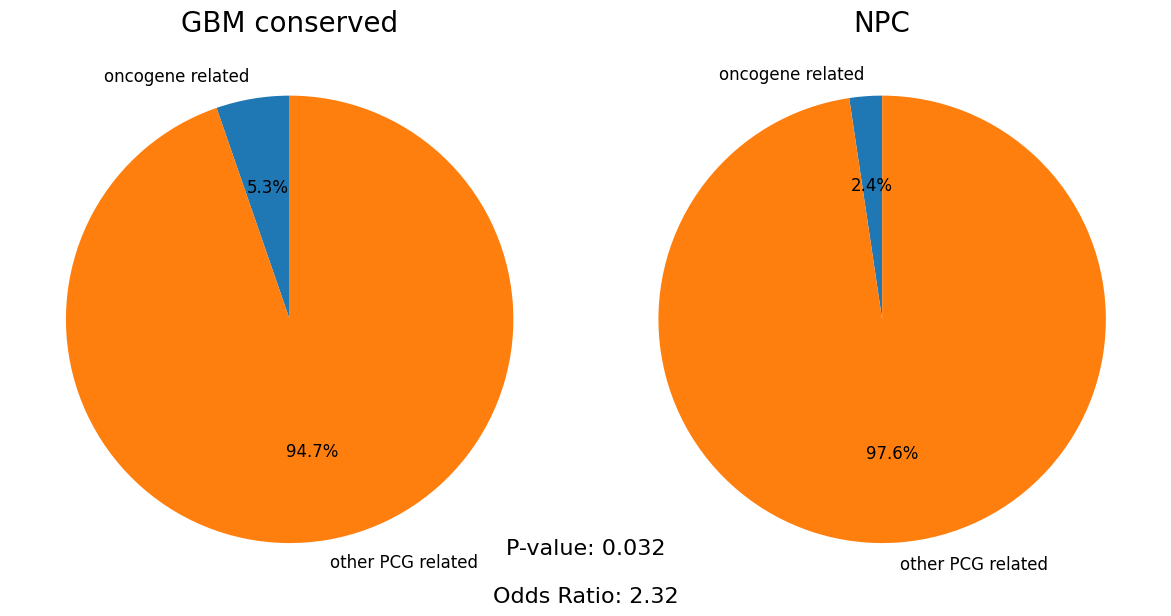

In [64]:
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, fisher_exact

# 饼图数据
table_data = [[8, 143], [83, 3443]]

# 计算期望频数并检查是否适合使用卡方检验
def are_expected_counts_sufficient(table_data):
    total = sum(sum(row) for row in table_data)
    row_totals = [sum(row) for row in table_data]
    col_totals = [row[0] + row[1] for row in zip(*table_data)]
    expected_counts = [(row_total * col_total) / total for row_total, col_total in zip(row_totals, col_totals)]
    return all(count >= 5 for count in expected_counts)

# 选择检验方法并执行检验
def perform_test(table_data):
    if are_expected_counts_sufficient(table_data):
        chi2, p, dof, expected = chi2_contingency(table_data)
        test_method = 'Chi-squared test' 
        return p, chi2, None, test_method  # 返回P值和卡方统计量，Odds Ratio为None
    else:
        oddsratio, p = fisher_exact(table_data)
        test_method = 'Fisher’s exact test'
        return p, None, oddsratio, test_method  # 返回P值，卡方统计量为None，Odds Ratio

# 执行检验
p_value, chi2_statistic, oddsratio, test_method = perform_test(table_data)
print(test_method)
# 创建饼图
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# 绘制饼图
for i, data in enumerate(table_data):
    ax[i].set_title(['GBM conserved', 'NPC'][i], fontsize=20)  # 设置标题和字体大小
    ax[i].pie(data, labels=['oncogene related', 'other PCG related'], autopct='%1.1f%%', startangle=90, textprops={'color': 'black', 'size': 12})

# 计算文本显示位置
p_value_y = 0.1  # 根据图表实际布局调整

# 显示P值
fig.text(0.5, p_value_y, f'P-value: {p_value:.3f}', ha='center', fontsize=16, color='black')

# 如果进行了卡方检验，显示卡方统计量
if chi2_statistic is not None:
    fig.text(0.5, p_value_y - 0.04, f'Chi-squared: {chi2_statistic:.2f}', ha='center', fontsize=16, color='black')

# 如果进行了Fisher精确检验，显示Odds Ratio
if oddsratio is not None:
    fig.text(0.5, p_value_y - 0.08, f'Odds Ratio: {oddsratio:.2f}', ha='center', fontsize=16, color='black')

# 显示图表
plt.tight_layout()
plt.show()

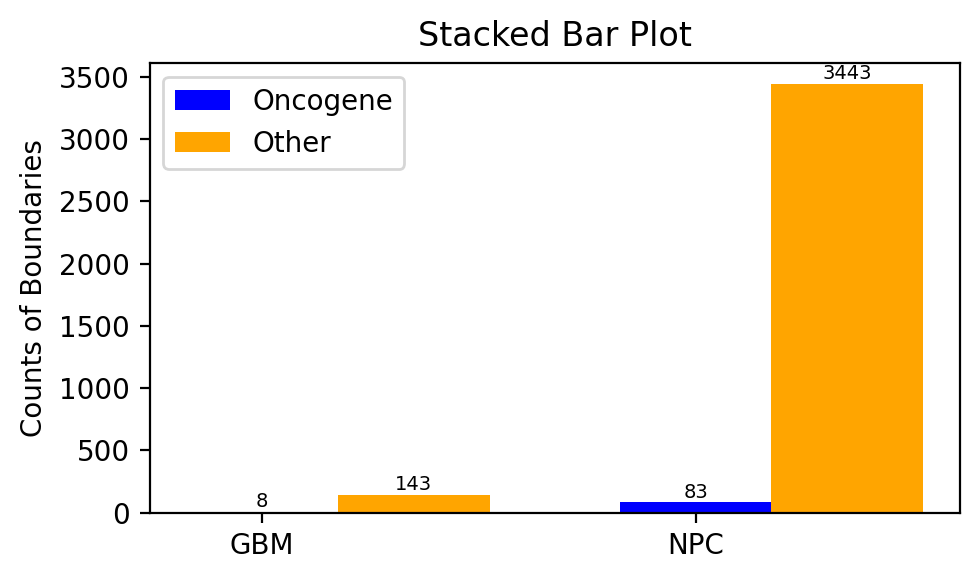

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# 您的输入数据
labels = ['GBM', 'NPC']
oncogene = [8, 83]
other = [143, 3443]

# 计算条形图的宽度和位置
width = 0.35  # 条形的宽度
index = np.arange(len(labels))  # 创建标签的位置索引

# 创建条形图
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
bar1 = ax.bar(index, oncogene, width, label='Oncogene', color='blue')
bar2 = ax.bar(index + width, other, width, label='Other', color='orange')

# 设置图表的标签和标题
#ax.set_xlabel('Groups')
ax.set_ylabel('Counts of Boundaries')
ax.set_title('Stacked Bar Plot')
ax.set_xticks([0, 1])  # 设置x轴的刻度位置
ax.set_xticklabels(labels)  # 设置x轴的标签

# 添加图例
ax.legend()

# 在每个条形上方添加数值标签
for i, (a, b) in enumerate(zip(index, oncogene)):
    plt.text(a, b + 5, '%d' % b, ha='center', va='bottom', fontsize=7)

for i, (a, c) in enumerate(zip(index + width, other)):
    plt.text(a, c + 5, '%d' % c, ha='center', va='bottom', fontsize=7)
# 显示图表
plt.tight_layout()  # 调整布局以适应标签
plt.show()

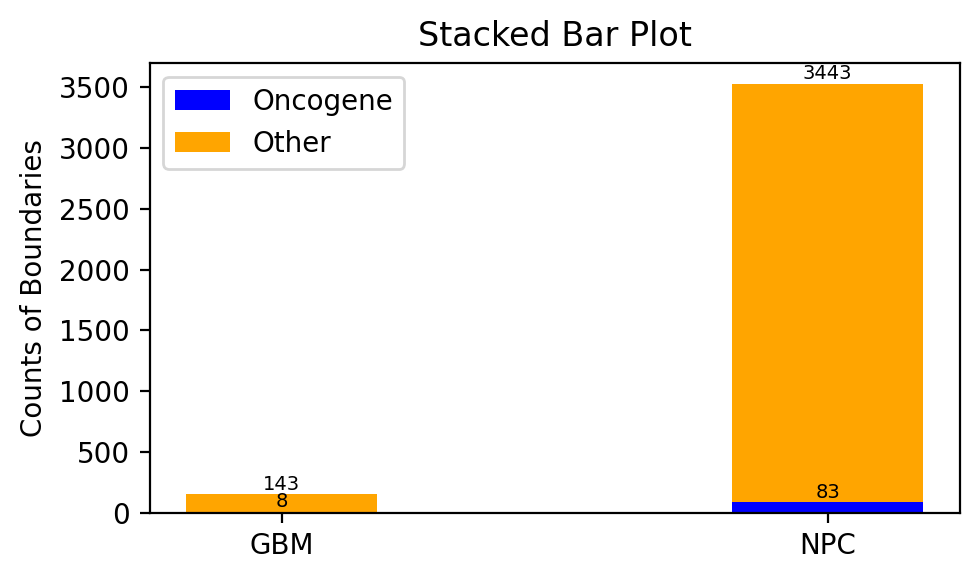

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# 您的输入数据
labels = ['GBM', 'NPC']
oncogene = [8, 83]
other = [143, 3443]

# 计算条形图的宽度和位置
width = 0.35  # 条形的宽度
index = np.arange(len(labels))  # 创建标签的位置索引

# 创建条形图
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)

# 首先绘制oncogene的条形
bar1 = ax.bar(index, oncogene, width, label='Oncogene', color='blue')

# 然后绘制other的条形，使用bottom参数堆叠在oncogene之上
bar2 = ax.bar(index, other, width, label='Other', color='orange', bottom=oncogene)

# 设置图表的标签和标题
ax.set_ylabel('Counts of Boundaries')
ax.set_title('Stacked Bar Plot')
ax.set_xticks([0, 1])  # 设置x轴的刻度位置
ax.set_xticklabels(labels)  # 设置x轴的标签

# 添加图例
ax.legend()

# 在每个条形的顶部添加数值标签
for i, (b1, b2) in enumerate(zip(oncogene, other)):
    # 为oncogene的条形添加标签
    plt.text(index[i], b1 + 5, '%d' % b1, ha='center', va='bottom', fontsize=7)
    # 为other的条形（堆叠在oncogene上）添加标签
    plt.text(index[i], b1 + b2 + 5, '%d' % b2, ha='center', va='bottom', fontsize=7)

# 显示图表
plt.tight_layout()  # 调整布局以适应标签
plt.show()

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# 您的输入数据
labels = ['GBM', 'NPC'] # GBM和NPC中oncogene的数量
other = [30, 1720]  
oncogene = [8, 83]
otherPCG = [143, 3443]
total_GBM = oncogene[0] + otherPCG[0] + other[0]
total_NPC = oncogene[1] + otherPCG[1] + other[1]
print(total_GBM,total_NPC)
# 计算oncogene和other的百分比
percentage_oncogene_GBM = (oncogene[0] / total_GBM) * 100
percentage_otherPCG_GBM = (otherPCG[0] / total_GBM) * 100
percentage_other_GBM = (other[0] / total_GBM) * 100

percentage_oncogene_NPC = (oncogene[1] / total_NPC) * 100
percentage_otherPCG_NPC = (otherPCG[1] / total_NPC) * 100
percentage_other_NPC = (other[1] / total_NPC) * 100
print(percentage_oncogene_GBM,percentage_oncogene_NPC,percentage_otherPCG_GBM,percentage_otherPCG_NPC,percentage_other_GBM,percentage_other_NPC)

#4.41988950276243 1.5821578345406022 79.00552486187846 65.63095691955776 16.574585635359114 32.78688524590164



181 5246
4.41988950276243 1.5821578345406022 79.00552486187846 65.63095691955776 16.574585635359114 32.78688524590164


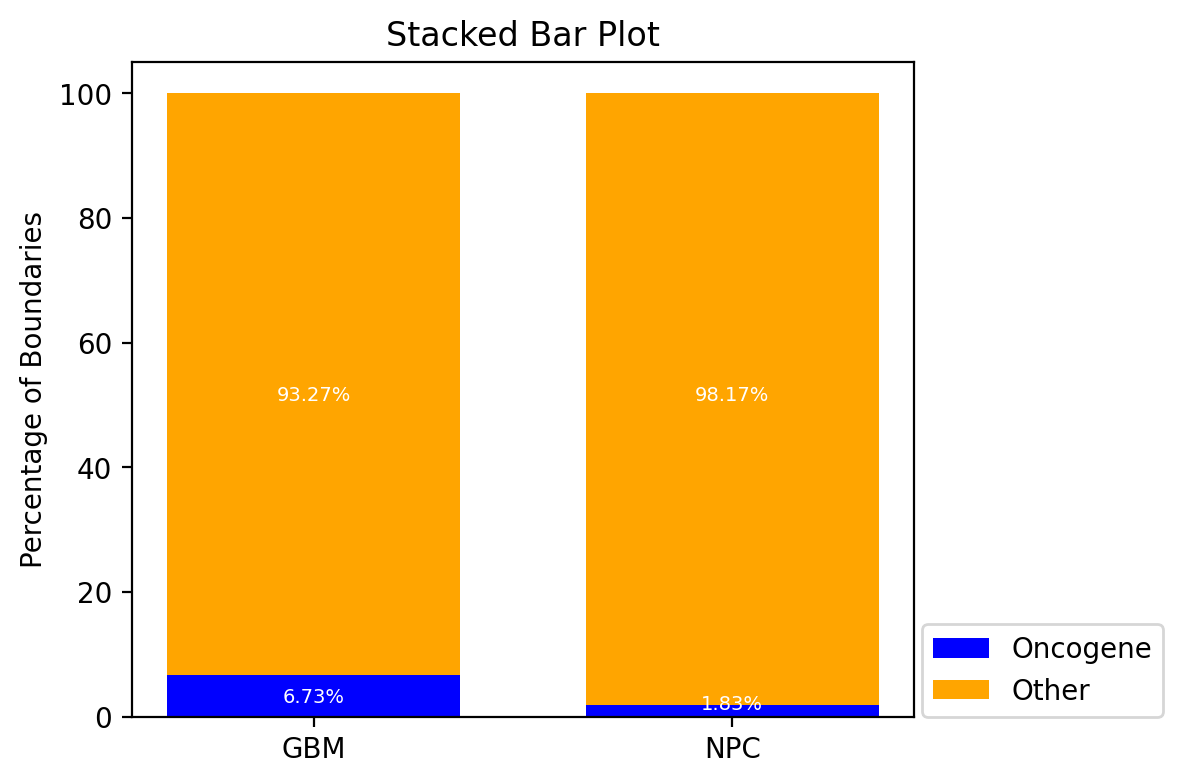

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 您的输入数据
labels = ['GBM', 'NPC']
oncogene = [6.730769230769231, 1.8258080434246236]
other = [93.26923076923077, 98.17419195657537]


# 计算条形图的宽度和位置
width = 0.35  # 条形的宽度
#index = np.arange(len(labels))  # 创建标签的位置索引
index = ([0.5, 1])
# 创建条形图
fig, ax = plt.subplots(figsize=(6, 4), dpi=200)

# 首先绘制oncogene的条形
bar1 = ax.bar(index, oncogene, width, label='Oncogene', color='blue')

# 然后绘制other的条形，使用bottom参数堆叠在oncogene之上
bar2 = ax.bar(index, other, width, label='Other', color='orange', bottom=oncogene)

# 设置图表的标签和标题
ax.set_ylabel('Percentage of Boundaries')
ax.set_title('Stacked Bar Plot')
ax.set_xticks(index)  # 设置x轴的刻度位置
ax.set_xticklabels(labels)  # 设置x轴的标签

# 添加图例
num1 = 1.01
num2 = 0
num3 = 3
num4 = 0
ax.legend(bbox_to_anchor=(num1, num2), loc=num3, borderaxespad=num4) ##bbox_to_anchor被赋予的二元组中，num1用于控制legend的左右移动，值越大越向右边移动，num2用于控制legend的上下移动，值越大，越向上移动。用于微调图例的位置。num1表示水平位置，num2表示垂直位置。



# 在每个条形的顶部添加数值标签，保留两位小数
for i, (b1, b2) in enumerate(zip(oncogene, other)):
    # 为oncogene的条形添加标签，使用格式化字符串保留两位小数
    plt.text(index[i], b1/4, f'{b1:.2f}%', ha='center', va='bottom', color='white',fontsize=7)
    # 为other的条形（堆叠在oncogene上）添加标签，使用格式化字符串保留两位小数
    plt.text(index[i], (b1 + b2)/2, f'{b2:.2f}%', ha='center', va='bottom', color='white',fontsize=7)

# 显示图表
plt.tight_layout(pad=1.0)  # 调整pad参数
plt.show()

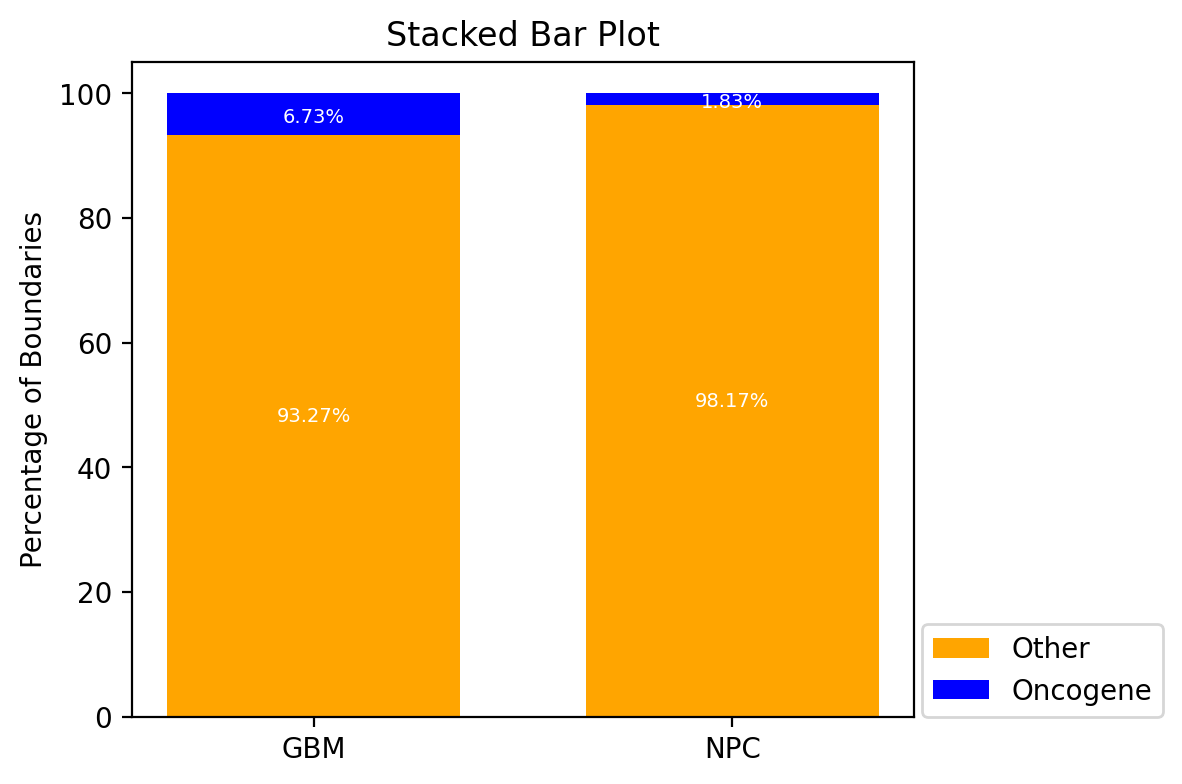

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# 您的输入数据
labels = ['GBM', 'NPC']
oncogene = [6.73, 1.83]
other = [93.27, 98.17]

# 计算条形图的宽度和位置
width = 0.35  # 条形的宽度
#index = np.arange(len(labels))  # 创建标签的位置索引
index = ([0.5, 1])
# 创建条形图
fig, ax = plt.subplots(figsize=(6, 4), dpi=200)

# 首先绘制oncogene的条形
bar1 = ax.bar(index, other, width, label='Other', color='orange')

# 然后绘制other的条形，使用bottom参数堆叠在oncogene之上
bar2 = ax.bar(index, oncogene, width, label='Oncogene', color='blue', bottom=other)

# 设置图表的标签和标题
ax.set_ylabel('Percentage of Boundaries')
ax.set_title('Stacked Bar Plot')
ax.set_xticks(index)  # 设置x轴的刻度位置
ax.set_xticklabels(labels)  # 设置x轴的标签

# 添加图例
num1 = 1.01
num2 = 0
num3 = 3
num4 = 0
ax.legend(bbox_to_anchor=(num1, num2), loc=num3, borderaxespad=num4) ##bbox_to_anchor被赋予的二元组中，num1用于控制legend的左右移动，值越大越向右边移动，num2用于控制legend的上下移动，值越大，越向上移动。用于微调图例的位置。num1表示水平位置，num2表示垂直位置。



# 在每个条形的顶部添加数值标签，保留两位小数
for i, (b1, b2) in enumerate(zip(other, oncogene)):
    # 为oncogene的条形添加标签，使用格式化字符串保留两位小数
    plt.text(index[i], b1/2, f'{b1:.2f}%', ha='center', va='bottom', color='white',fontsize=7)
    # 为other的条形（堆叠在oncogene上）添加标签，使用格式化字符串保留两位小数
    plt.text(index[i], b1 + b2/2 - 2, f'{b2:.2f}%', ha='center', va='bottom', color='white',fontsize=7)

# 显示图表
plt.tight_layout(pad=1.0)  # 调整pad参数
plt.show()

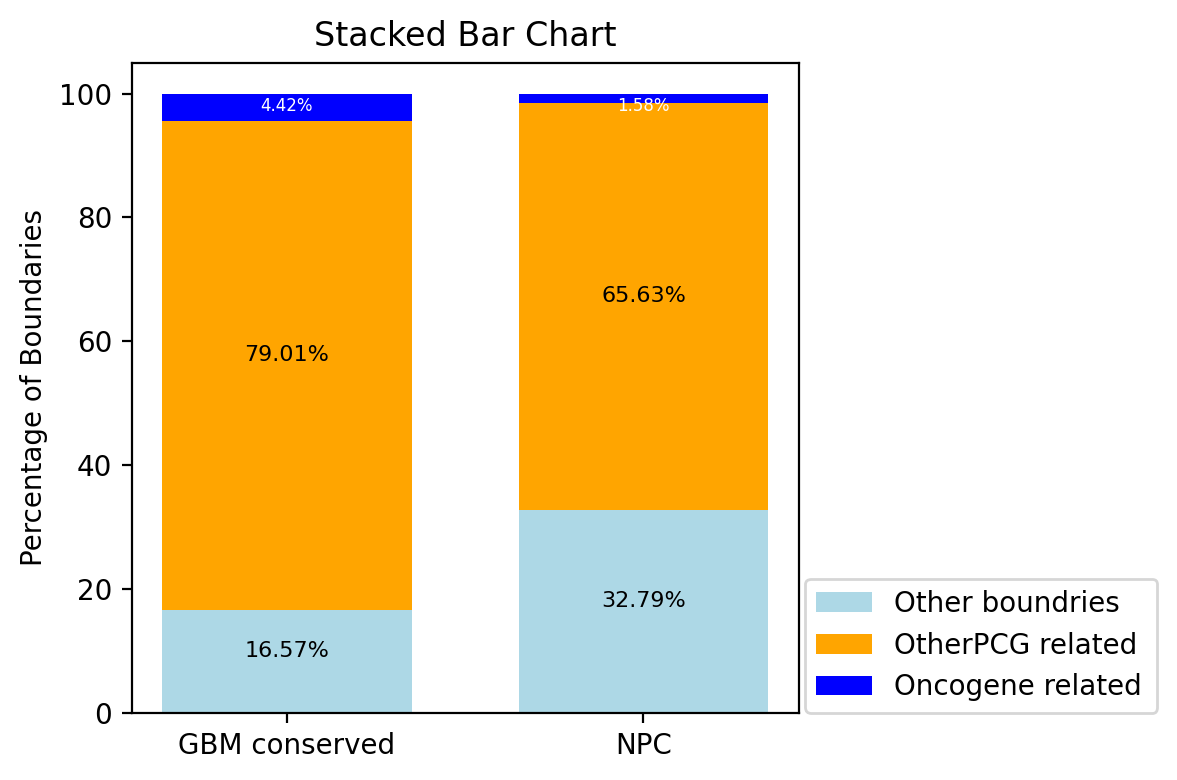

In [69]:
import matplotlib.pyplot as plt
import numpy as np

#print(percentage_oncogene_GBM,percentage_oncogene_NPC,percentage_otherPCG_GBM,percentage_otherPCG_NPC,percentage_other_GBM,percentage_other_NPC)
#4.41988950276243 1.5821578345406022 79.00552486187846 65.63095691955776 16.574585635359114 32.78688524590164


# 您的输入数据
labels = ['GBM conserved', 'NPC']
oncogene = np.array([4.42, 1.58])
otherPCG = np.array([79.01, 65.63])
other = np.array([16.57, 32.79])

# 计算条形图的宽度和位置
width = 0.35  # 条形的宽度
index = ([0.5, 1])  # 创建标签的位置索引

# 创建条形图
fig, ax = plt.subplots(figsize=(6, 4), dpi=200)

# 绘制每个数据集的条形，并堆叠它们
bar_other = ax.bar(index, other, width, label='Other boundries', color='lightblue')
bar_otherPCG = ax.bar(index, otherPCG, width, label='OtherPCG related ', color='orange', bottom=other)
bar_oncogene = ax.bar(index, oncogene, width, label='Oncogene related', color='blue', bottom=otherPCG + other)

# 设置图表的标签和标题
ax.set_ylabel('Percentage of Boundaries')
ax.set_title('Stacked Bar Chart')
ax.set_xticks(index)
ax.set_xticklabels(labels)


# 定义一个函数来为堆叠的条形图添加数值标签
def add_value_labels(ax, index, bottom_values, values, label, color='white', fontsize=7, oncogene_fixed_height=None):
    for i, (bottom, value) in enumerate(zip(bottom_values, values)):
        # 对于oncogene柱子，如果提供了固定高度，则使用它
        if label == 'Oncogene' and oncogene_fixed_height is not None:
            label_y = oncogene_fixed_height
        else:
            # 否则，计算标签的垂直位置
            label_y = bottom + value / 2
        ax.text(index[i], label_y, f'{value:.2f}%', ha='center', va='bottom', color=color, fontsize=fontsize)

# 为每个堆叠的条形图添加数值标签
add_value_labels(ax, index, [0]*len(other), other, 'Other', color='black', fontsize=8)
add_value_labels(ax, index, other, otherPCG, 'OtherPCG', color='black', fontsize=8)
add_value_labels(ax, index, other + otherPCG, oncogene, 'Oncogene', color='white', fontsize=6, oncogene_fixed_height=96.5)

# 设置图例
ax.legend(bbox_to_anchor=(1.01, 0), loc='lower left', borderaxespad=0)

# 显示图表
plt.tight_layout()
plt.show()

# 差异 boundaries and TADs

In [ ]:
##产生4列，为差异boundary和tad作准备
# 打开输入文件和输出文件
with open('/cluster/home/tmp/GBM/HiC/08TAD/all.bed', 'r') as infile, open('/cluster/home/tmp/GBM/HiC/08TAD/all_4col.bed', 'w') as outfile:
    # 写入标题行，假设输入文件有标题行
    header_line = infile.readline().strip()
    header_columns = header_line.split('\t')[:3]
    new_header = '\t'.join(header_columns + ['is_boundary_800000']) + '\n'

# 写入修改后的标题行到输出文件
    outfile.write(new_header)
    
    # 逐行读取输入文件
    for line in infile:
        # 分割行内容
        parts = line.strip().split()
        
        # 检查是否包含'False'
        if 'False' in parts[3:]:
            is_boundary = 'False'
        else:
            is_boundary = 'True'
        
        # 写入前三列和新列到输出文件
        outfile.write('\t'.join(parts[:3] + [is_boundary]) + '\n')



In [ ]:
###计算单个GBM样本与NPC的差异边界，源代码：https://github.com/open2c/quaich/blob/e153a579a31f966968eb8c63a32aa6ff63c5a6e2/workflow/rules/insulation_tads.smk#L42
import pandas as pd

# 假设的文件路径和配置参数
insulation_folder = '/cluster/home/tmp/GBM/HiC/09insulation/cooltools_insulation/per_sample'
boundaries_folder = '/cluster/home/tmp/GBM/HiC/08TAD'

config = {
    'compare_boundaries': {'fold_change_threshold': 2},
    'TADs': {'max_tad_length': 1000000},
    # 其他配置...
}

# 读取和处理绝缘性数据的函数
def process_insulation_data(wt_file, ko_file, output_file, fold_change_threshold):
    # 读取数据
    insWT = pd.read_csv(wt_file, sep="\t")
    insKO = pd.read_csv(ko_file, sep="\t")

    # 过滤掉is_bad_bin为True的行
    insWT = insWT[insWT['is_bad_bin'] == False].drop(columns=['is_bad_bin'])
    insKO = insKO[insKO['is_bad_bin'] == False].drop(columns=['is_bad_bin'])

    # 合并数据
    ins = pd.merge(insWT, insKO, suffixes=('_WT', '_KO'), on=['chrom', 'start', 'end'])

    # 计算差异边界
    diff_ins = ins[
        (ins[f'boundary_strength_800000_WT'] / ins[f'boundary_strength_800000_KO']) >= fold_change_threshold
        | (ins[f'is_boundary_800000_WT'] & ~ins[f'is_boundary_800000_KO'])
    ]

    # 保存差异边界
    diff_ins[['chrom', 'start', 'end']].to_csv(output_file, header=False, index=False, sep="\t")

wt_file = f'{insulation_folder}/A172_insul.tsv'
ko_file = f'{insulation_folder}/NPC_insul.tsv'
output_file = f'{boundaries_folder}/Diff_boundaries_A172_vs_NPC_2.bed'

process_insulation_data(wt_file, ko_file, output_file, config['compare_boundaries']['fold_change_threshold'])


In [ ]:
###IS产生tad，源代码：https://github.com/open2c/quaich/blob/e153a579a31f966968eb8c63a32aa6ff63c5a6e2/workflow/rules/insulation_tads.smk#L42
import pandas as pd

# 假设的文件路径和配置参数
insulation_folder = '/cluster/home/tmp/GBM/HiC/08TAD'
tads_folder = '/cluster/home/tmp/GBM/HiC/08TAD'
config = {
    'TADs': {'max_tad_length': 1000000},
}

# 用于识别TADs的函数
def identify_tads(insulation_file, output_file, max_tad_length):
    # 读取绝缘性数据
    ins = pd.read_csv(insulation_file, sep="\t")
    
    # 过滤掉is_boundary列中标记为True的行，即非边界区域
    non_boundaries = ins[ins['is_boundary_800000'] == False]
    
    # 过滤掉长度超过最大TAD长度的区域
    tads = non_boundaries[(non_boundaries['end'] - non_boundaries['start']) <= max_tad_length]
    
    # 重置索引并保存TADs到文件
    tads.reset_index(drop=True)
    tads[['chrom', 'start', 'end']].to_csv(output_file, header=False, index=False, sep="\t")

# 示例使用
# 假设我们有一个文件：sample_10000.insulation.tsv
insulation_file = f'{insulation_folder}/all_4col.bed'
output_file = f'{tads_folder}/all_4col_tad.bed'

identify_tads(insulation_file, output_file, config['TADs']['max_tad_length'])
